In [1]:
%pip install -Uq upgini
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot as plt, style
style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
from warnings import filterwarnings, simplefilter
filterwarnings('ignore')
simplefilter('ignore')

Note: you may need to restart the kernel to use updated packages.


In [2]:
train_start = "2013-01-01"
train_end = "2017-08-15"
test_start = "2017-08-16"
test_end = "2017-08-31"

train = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv',
                    parse_dates = ['date'], infer_datetime_format = True,
                    dtype = {'store_nbr' : 'category',
                             'family' : 'category'},
                    usecols = ['date', 'store_nbr', 'family', 'sales'])
train = train.set_index(['date', 'store_nbr', 'family']).sort_index()
print(train.shape)
train.head()

(3000888, 1)


sales
date       store_nbr family           
2013-01-01 1         AUTOMOTIVE    0.0
                     BABY CARE     0.0
                     BEAUTY        0.0
                     BEVERAGES     0.0
                     BOOKS         0.0

In [3]:
test = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv',
                   parse_dates = ['date'], infer_datetime_format = True)
test = test.set_index(['date', 'store_nbr', 'family']).sort_values('id')
print(test.shape)
test.head()

(28512, 2)


id  onpromotion
date       store_nbr family                          
2017-08-16 1         AUTOMOTIVE  3000888            0
                     BABY CARE   3000889            0
                     BEAUTY      3000890            2
                     BEVERAGES   3000891           20
                     BOOKS       3000892            0

### oil特徴量の追加

In [4]:
oil = pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv',
                  parse_dates = ['date'], infer_datetime_format = True,
                  index_col = 'date')
oil['avg_oil'] = oil['dcoilwtico'].rolling(7).mean()
df_oil = pd.DataFrame(index=pd.date_range(train_start, test_end), columns=["dcoilwtico", "avg_oil"])
df_oil.loc[train_start:test_end, :] = oil.loc[train_start:test_end]
df_oil = df_oil.astype(np.float64).interpolate()
df_oil.tail()

,dcoilwtico,avg_oil
2017-08-27,46.816667,47.656190
2017-08-28,46.400000,47.624286
2017-08-29,46.460000,47.320000
2017-08-30,45.960000,47.115714
2017-08-31,47.260000,47.060000


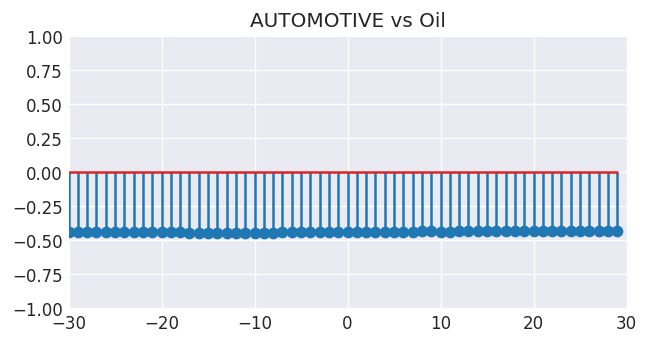

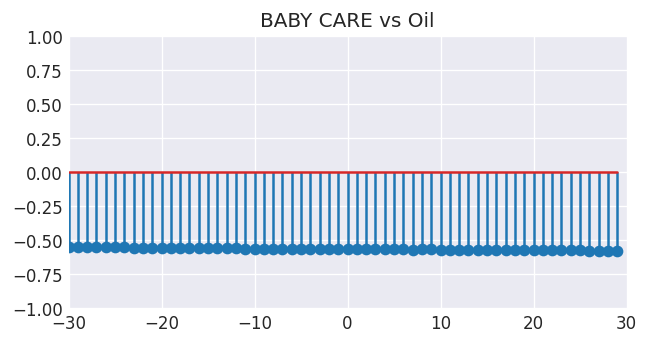

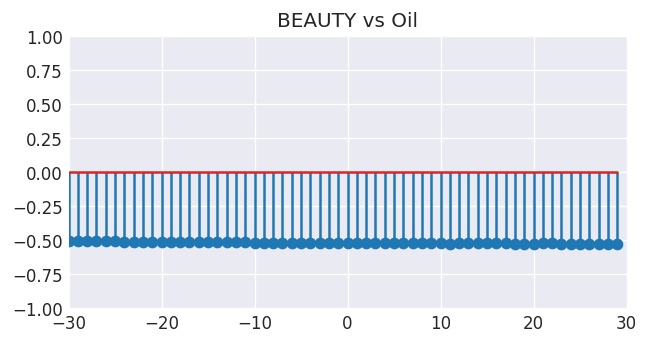

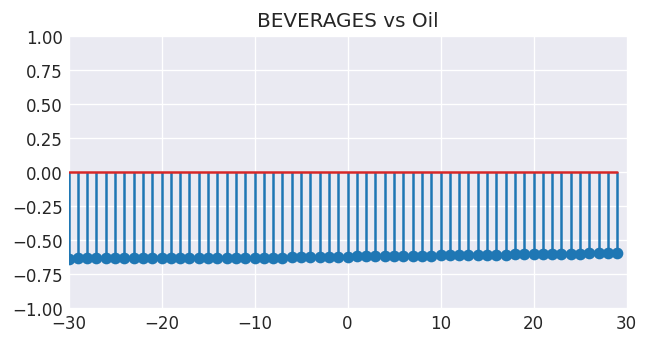

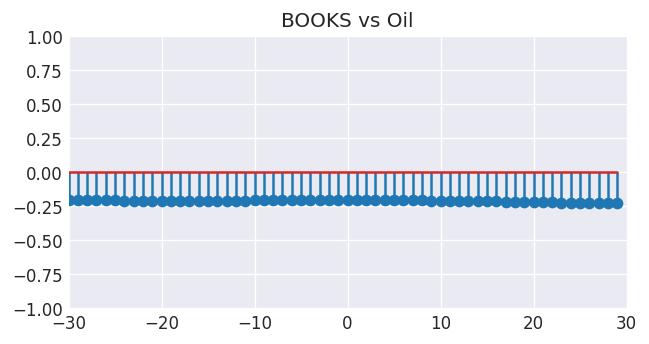

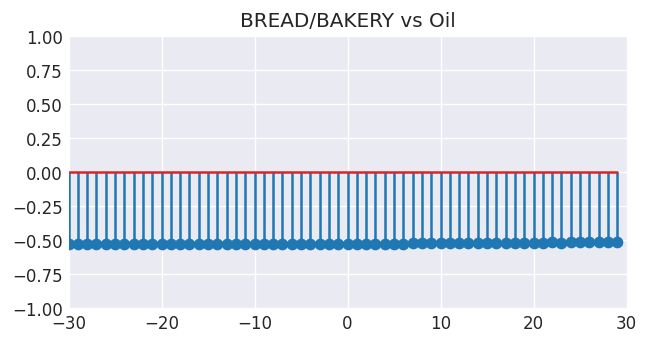

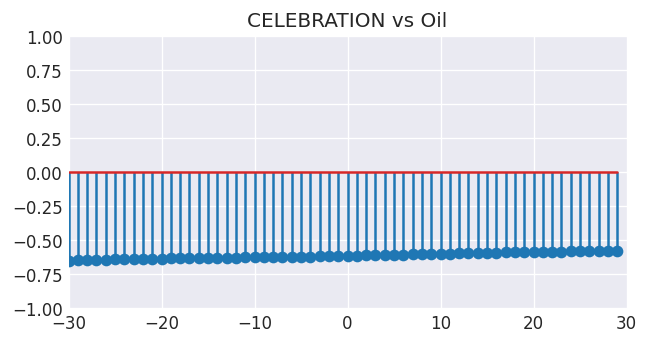

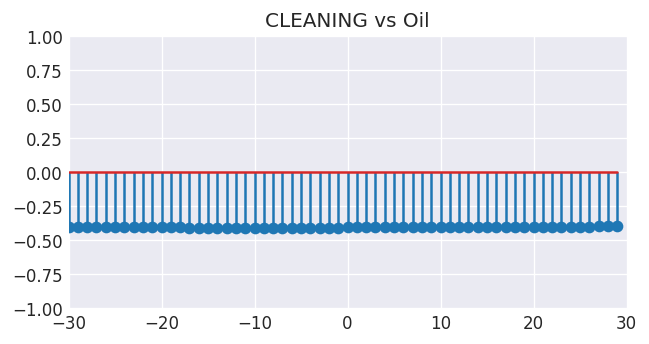

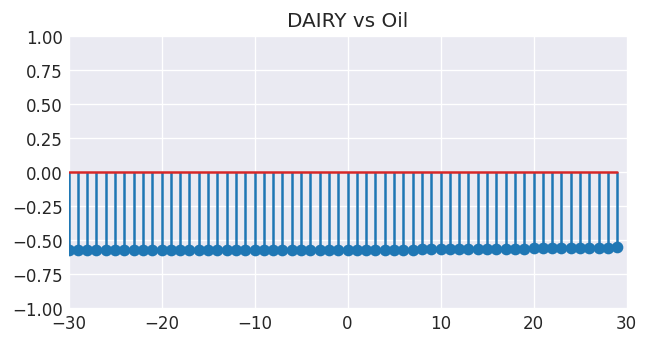

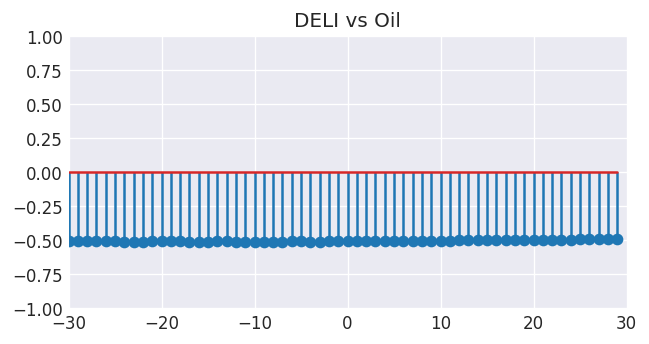

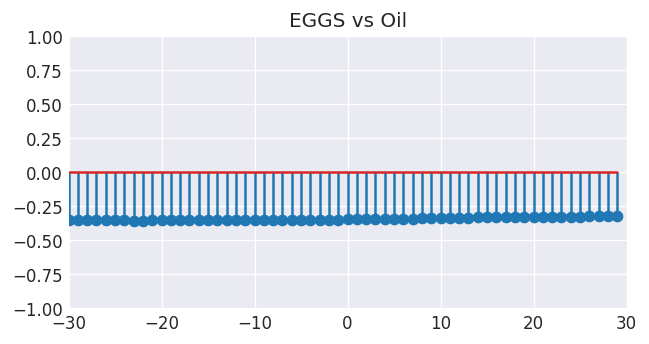

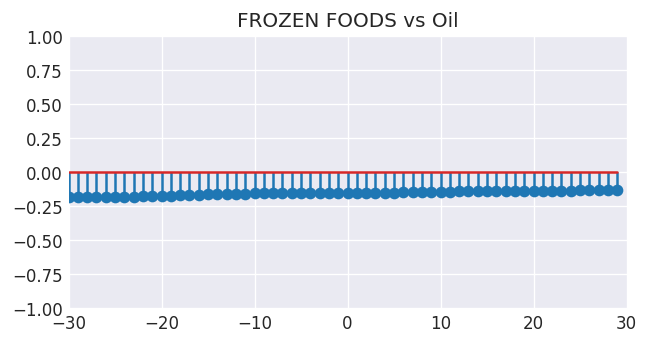

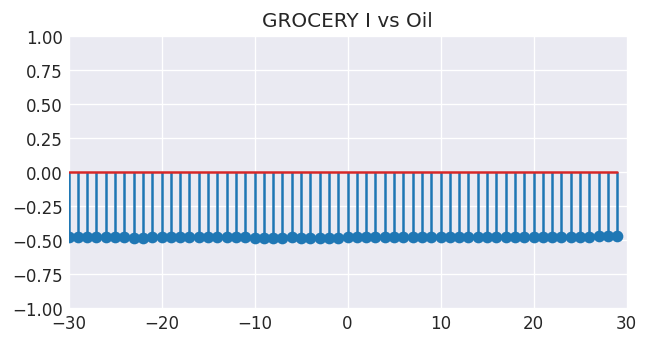

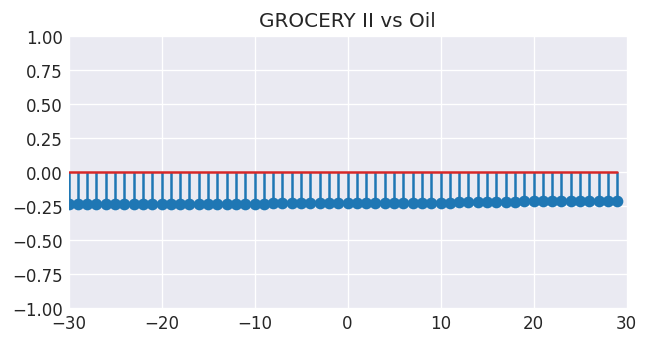

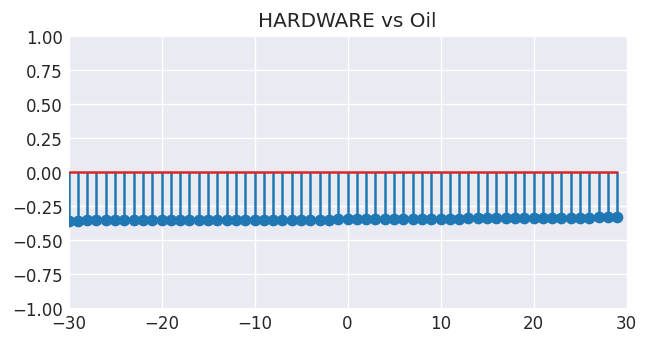

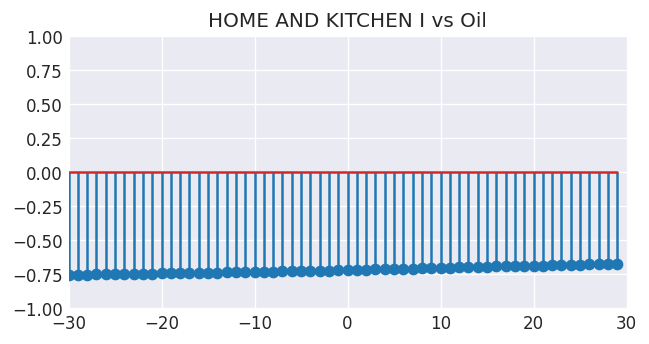

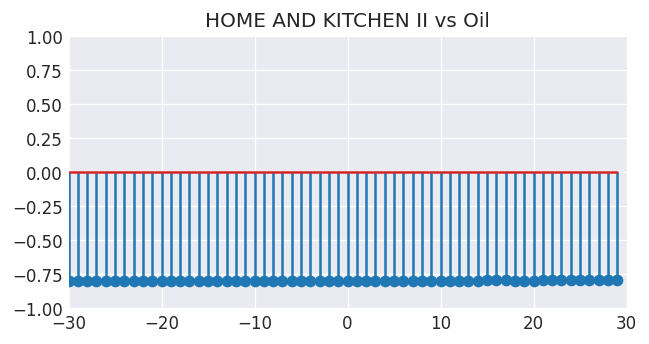

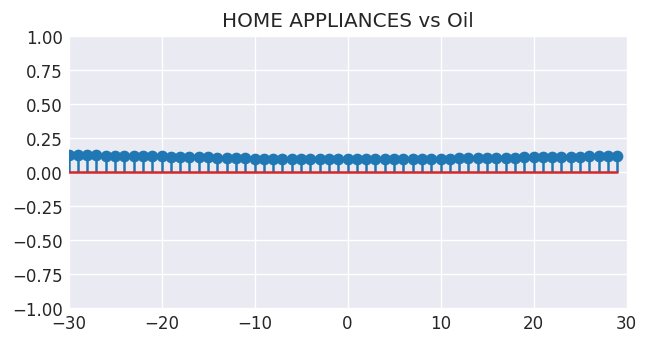

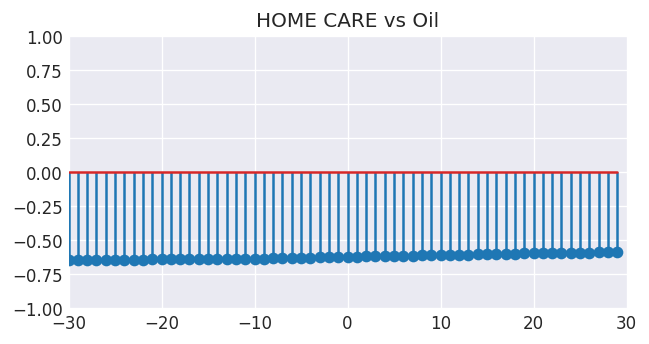

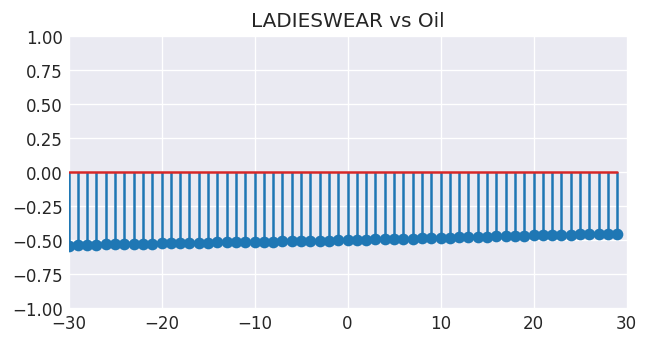

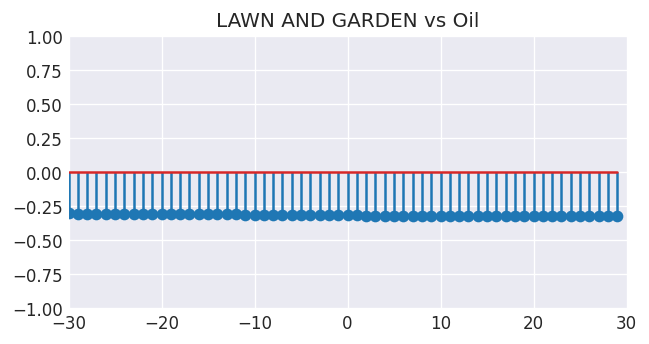

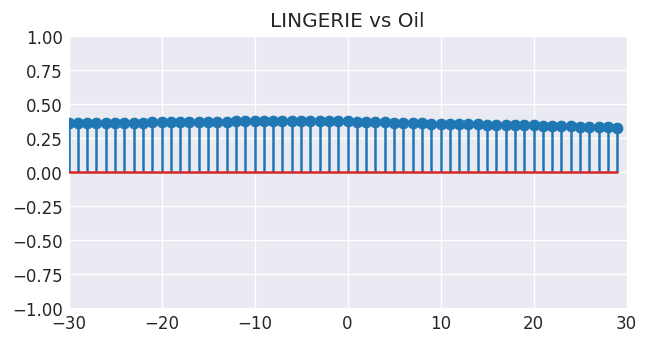

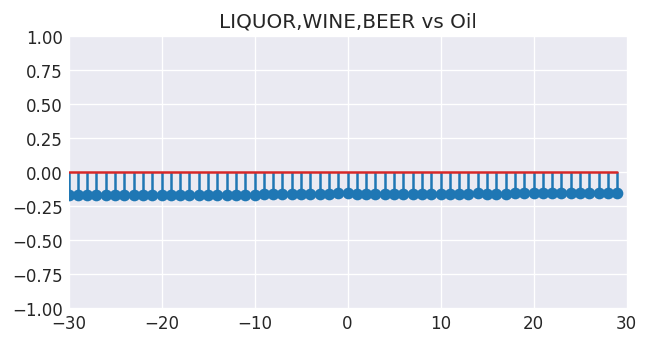

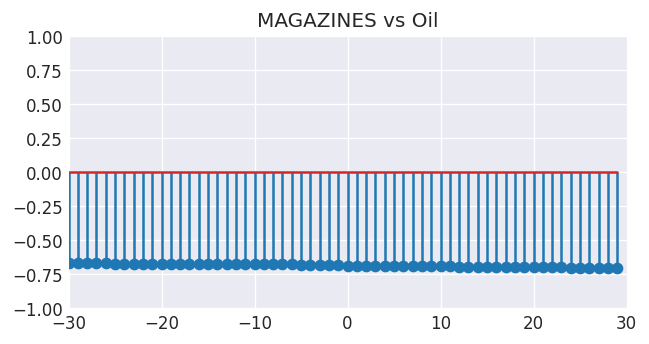

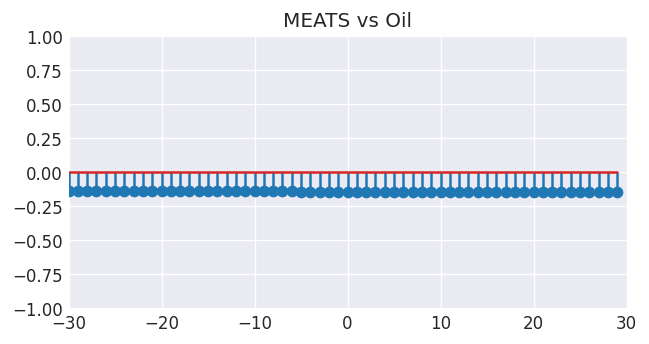

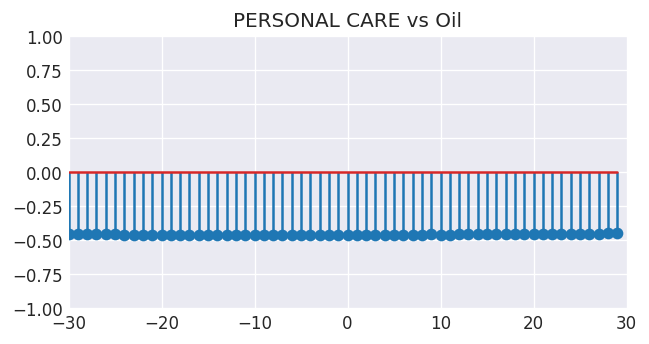

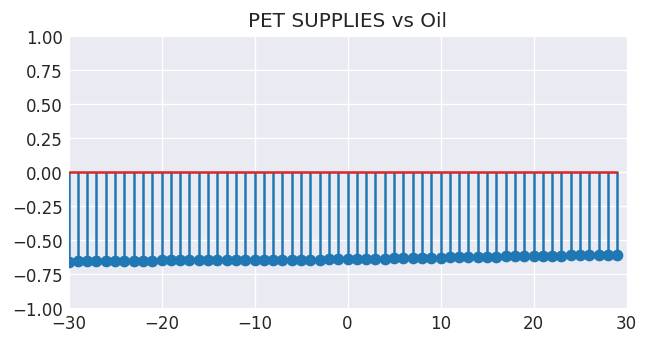

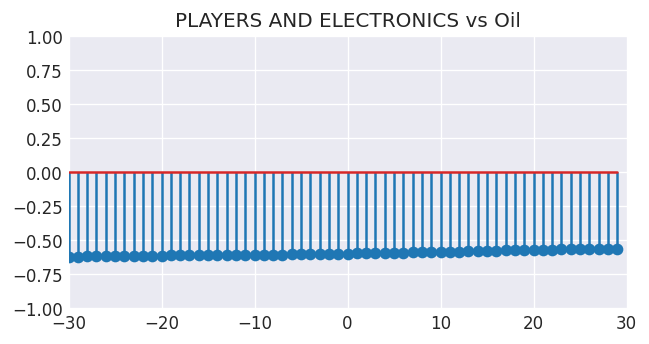

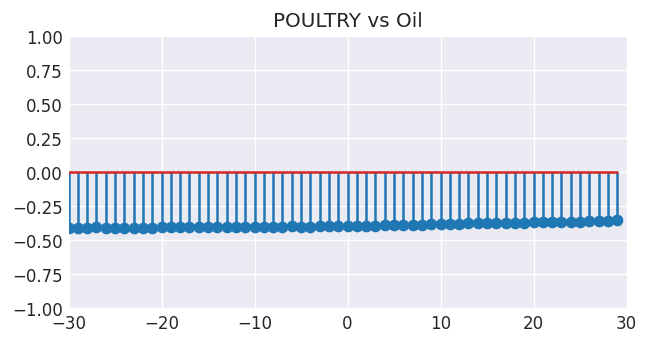

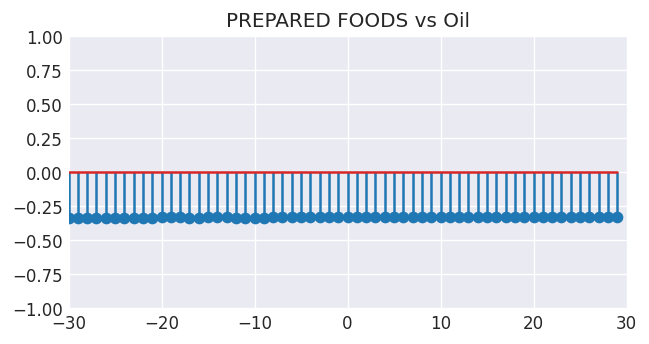

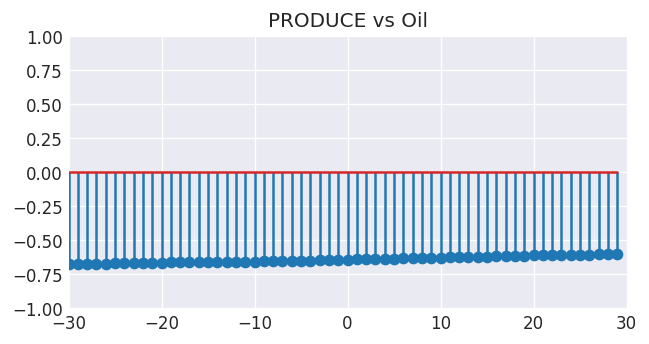

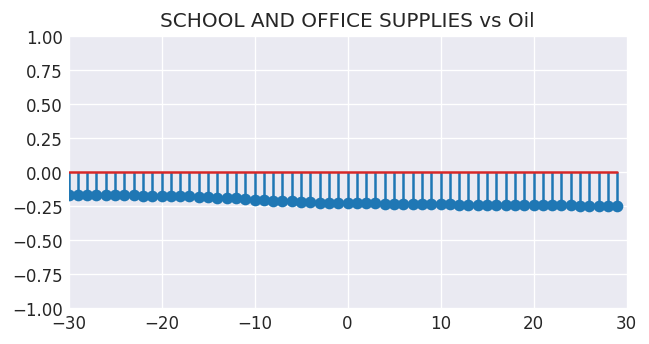

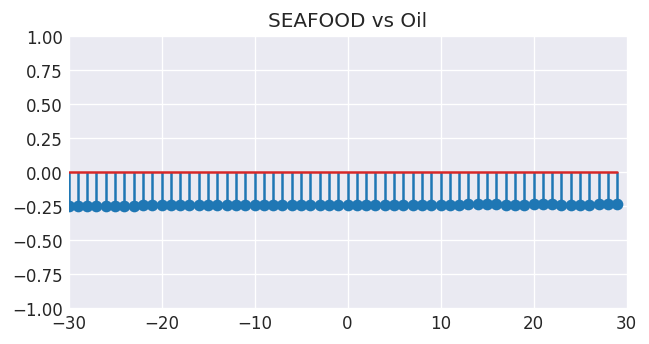

In [5]:
import statsmodels.api as sm

st = "2013-01-10"
ed = "2017-08-15"

y_oil = df_oil.loc[st:ed]["dcoilwtico"]
data = train.groupby(["date", "family"]).mean()
familys = data.index.get_level_values("family").unique()
plot_size = 30

for family in familys:
    # salesデータはクリスマスが欠損してるので補完する
    a = pd.DataFrame(data.query(" family==@family ").sales.to_numpy(), index=pd.to_datetime(data.query(" family==@family ").index.get_level_values("date")), columns=["sales"])
    df_new = pd.DataFrame(index=pd.date_range(st, ed), columns=["sales"])
    df_new.loc[a.loc[st:ed].index, :] = a.loc[st:ed]
    df_new["sales"] = df_new["sales"].fillna(0) # クリスマスは売り上げ0にしておく
    y_family = df_new["sales"].to_numpy().reshape(-1, )
    ccf_xy = sm.tsa.ccf(y_family, y_oil)[1:plot_size+1]
    ccf_yx = sm.tsa.ccf(y_oil, y_family)[:plot_size]
    ccf = np.concatenate([ccf_yx[::-1], ccf_xy])
    
    x_axis = np.arange(-plot_size, plot_size)
    fig = plt.figure(figsize=(6, 3), dpi=120)
    ax = fig.add_subplot(111)
    ax.stem(x_axis, ccf)
    ax.set_xlim([-plot_size, plot_size])
    ax.set_ylim([-1, 1])
    ax.set_title(f"{family} vs Oil")
    plt.show()

In [6]:
add_f = pd.DataFrame(index=pd.date_range(train_start, test_end), columns=["dcoilwtico", "avg_oil"])
add_f.loc[train_start:test_end, :] = df_oil.loc[train_start:test_end]
add_f.head()

,dcoilwtico,avg_oil
2013-01-01,NaN,NaN
2013-01-02,93.14,NaN
2013-01-03,92.97,NaN
2013-01-04,93.12,NaN
2013-01-05,93.146667,NaN


### 曜日の追加

In [7]:
dow = pd.date_range(train_start, test_end).dayofweek + 1
add_f["dayofweek_cos"] = np.cos(2 * np.pi * dow / dow.max())
add_f["dayofweek_sin"] = np.sin(2 * np.pi * dow / dow.max())
add_f.head(10)

,dcoilwtico,avg_oil,dayofweek_cos,dayofweek_sin
2013-01-01,NaN,NaN,-0.222521,9.749279e-01
2013-01-02,93.14,NaN,-0.900969,4.338837e-01
2013-01-03,92.97,NaN,-0.900969,-4.338837e-01
2013-01-04,93.12,NaN,-0.222521,-9.749279e-01
2013-01-05,93.146667,NaN,0.623490,-7.818315e-01
2013-01-06,93.173333,NaN,1.000000,-2.449294e-16
2013-01-07,93.2,NaN,0.623490,7.818315e-01
2013-01-08,93.21,NaN,-0.222521,9.749279e-01
2013-01-09,93.08,NaN,-0.900969,4.338837e-01
2013-01-10,93.81,93.218571,-0.900969,-4.338837e-01


### 祝日の追加

In [8]:
hol = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv',
                  parse_dates = ['date'], infer_datetime_format = True, index_col = 'date')
hol = hol[hol.locale == 'National']  # National holidayだけ使う
hol = hol.groupby(hol.index).first() # 重複してる日付は消す
add_f = pd.concat([add_f, hol], axis=1).loc[train_start:test_end] 
add_f["wd"] = 1 # Work Day
add_f.loc[add_f.index.dayofweek > 4, "wd"] = 0 # 土日はWork Dayじゃない
add_f.loc[add_f.type=="Work Day", "wd"] = 1 # Work Day
add_f.loc[add_f.type=="Transfer", "wd"] = 0 # 祝日転送?
add_f.loc[add_f.type=="Bridge", "wd"] = 0
add_f.loc[(add_f.type == 'Holiday') & (add_f.transferred == False), 'wd'] = 0 # 祝日で転送されてない
add_f.loc[(add_f.type == 'Holiday') & (add_f.transferred == True), 'wd'] = 1 # 祝日だけど別日に転送されたのでWork Day
add_f = pd.get_dummies(add_f, columns = ['type']) # 
add_f.drop(['locale', 'locale_name', 'description', 'transferred'], axis=1, inplace=True) # Unused columns

add_f.head()

,dcoilwtico,avg_oil,dayofweek_cos,dayofweek_sin,wd,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
2013-01-01,NaN,NaN,-0.222521,0.974928,0,0,0,0,1,0,0
2013-01-02,93.14,NaN,-0.900969,0.433884,1,0,0,0,0,0,0
2013-01-03,92.97,NaN,-0.900969,-0.433884,1,0,0,0,0,0,0
2013-01-04,93.12,NaN,-0.222521,-0.974928,1,0,0,0,0,0,0
2013-01-05,93.146667,NaN,0.623490,-0.781831,1,0,0,0,0,0,1


### 給料日

In [9]:
add_f["wageday"] = ((add_f.index.is_month_end) | (add_f.index.day==15)).astype(int)
add_f.head()

,dcoilwtico,avg_oil,dayofweek_cos,dayofweek_sin,wd,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,wageday
2013-01-01,NaN,NaN,-0.222521,0.974928,0,0,0,0,1,0,0,0
2013-01-02,93.14,NaN,-0.900969,0.433884,1,0,0,0,0,0,0,0
2013-01-03,92.97,NaN,-0.900969,-0.433884,1,0,0,0,0,0,0,0
2013-01-04,93.12,NaN,-0.222521,-0.974928,1,0,0,0,0,0,0,0
2013-01-05,93.146667,NaN,0.623490,-0.781831,1,0,0,0,0,0,1,0


### school season

In [10]:
school_season = []
for i, r in add_f.iterrows():
    if i.month in [4, 5, 8, 9] :
        school_season.append(1)
    else :
        school_season.append(0)
add_f['school_season'] = school_season
add_f.head()

,dcoilwtico,avg_oil,dayofweek_cos,dayofweek_sin,wd,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,wageday,school_season
2013-01-01,NaN,NaN,-0.222521,0.974928,0,0,0,0,1,0,0,0,0
2013-01-02,93.14,NaN,-0.900969,0.433884,1,0,0,0,0,0,0,0,0
2013-01-03,92.97,NaN,-0.900969,-0.433884,1,0,0,0,0,0,0,0,0
2013-01-04,93.12,NaN,-0.222521,-0.974928,1,0,0,0,0,0,0,0,0
2013-01-05,93.146667,NaN,0.623490,-0.781831,1,0,0,0,0,0,1,0,0


In [11]:
y = train.unstack(['store_nbr', 'family'])
y.head()

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0        0.000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0      470.652   
2013-01-03        3.0       0.0    0.0     919.0   0.0      310.655   
2013-01-04        3.0       0.0    3.0     953.0   0.0      198.366   
2013-01-05        5.0       0.0    3.0    1160.0   0.0      301.057   

                                                 ...                     \
store_nbr                                        ...         9            
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES    MEATS   
date                                             ...                      
2013-01-01         0.0      0.0    0.0    0.000  ...       0.0    0.000   
2013-01-02         0.0   1060.0  579.0  164.069  ...       0.0  374.531   
2013-01-03         0.0    836.0  453.0  151.582  ...       0.0  400.863   
2013-01-04         0.0    827.0  460.0  131.411  ...       0.0  310.878   
2013-01-05         0.0    811.0  464.0  118.613  ...       0.0  447.685   

                                                                        \
store_nbr                                                                
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS  POULTRY   
date                                                                     
2013-01-01           0.0          0.0                     0.0    0.000   
2013-01-02         482.0          0.0                     0.0  651.292   
2013-01-03         372.0          0.0                     0.0  509.496   
2013-01-04         324.0          0.0                     0.0  332.672   
2013-01-05         461.0          0.0                     0.0  510.919   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01            0.0     0.0                        0.0   0.000  
2013-01-02           83.0     0.0                        0.0  29.214  
2013-01-03           66.0     0.0                        0.0  25.000  
2013-01-04           57.0     0.0                        0.0  11.000  
2013-01-05           84.0     0.0                        0.0  28.361  

[5 rows x 1782 columns]

upginiで特徴量の追加

In [12]:
%pip install -Uq upgini
from upgini import FeaturesEnricher, SearchKey, ModelTaskType
from upgini.metadata import CVType

enricher = FeaturesEnricher(
    search_keys={
        "date": SearchKey.DATE # 日付に関連する情報を探す
    },
    country_code = "EC", # エクアドル
    cv = CVType.time_series
)

Note: you may need to restart the kernel to use updated packages.


In [18]:
enriched_ts_map = {}
y_fe_1 = train.groupby(["date", "family"]).mean().query(" family=='SCHOOL AND OFFICE SUPPLIES' ").reset_index().set_index(["date"]).drop(["family"], axis=1).sales
y_fe_2 = train.groupby(["date", "family"]).mean().query(" family=='LINGERIE' ").reset_index().set_index(["date"]).drop(["family"], axis=1).sales

y_fe_1 = np.log1p(y_fe_1)
y_fe_2 = np.log1p(y_fe_2)

In [22]:
# クリスマスの売り上げデータが抜けているので0で補完する
time_idx = pd.to_datetime(["2013-12-25", "2014-12-25", "2015-12-25", "2016-12-25"])
ch = pd.Series([0, 0, 0, 0], index=time_idx)

y_fe_1 = y_fe_1.append(ch).sort_index()
y_fe_2 = y_fe_2.append(ch).sort_index()

In [23]:
from upgini import FeaturesEnricher, SearchKey, ModelTaskType
from upgini.metadata import RuntimeParameters, CVType

# 持ってるデータ期間全部使って特徴量サーチ
add_f.index.name = "date" 
x = add_f.loc[:"2017-08-15"]
xtest = add_f.loc["2017-08-16":]

X_enriched = enricher.fit_transform(
    x.copy().reset_index(), 
    y_fe_1.reset_index(drop=True).values,
    calculate_metrics=True,
    keep_input=True, 
    max_features=2,  
).set_index("date")

X_test_enriched = enricher.transform(
    xtest.copy().reset_index(),
    keep_input=True,
    max_features=2, 
).set_index("date")

Detected task type: ModelTaskType.REGRESSION
Columns ['type_bridge', 'type_transfer', 'type_work_day'] has value with frequency more than 99% and has been droped from X
Columns ['avg_oil'] has high cardinality (>90% unique values) and has been droped from X


Column name,Status,Description
date,All valid,All values in this column are good to go
target,All valid,All values in this column are good to go


Running search request with search_id=2b13baaf-8174-4af5-8b5e-176b1fec432e
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com
Done


53 relevant feature(s) found with the search keys: ['date', 'country_iso_code'].


,feature_name,shap_value,coverage %,type
0,f_cci_pca_1_0ca24b1e,0.201545,100.0,NUMERIC
1,f_nasdaq_d309709a,0.093498,100.0,NUMERIC
2,f_us_days_from_election_1658c931,0.081324,100.0,NUMERIC
3,f_workdays_in_month_cnt_49b86b81,0.068393,100.0,NUMERIC
4,f_BCA_20ac5d47,0.061600,100.0,NUMERIC
5,f_cci_umap_9_8ee577ed,0.033985,100.0,NUMERIC
6,f_year_cos6_da9f5b6c,0.024673,100.0,NUMERIC
7,f_cci_umap_7_db76d645,0.022579,100.0,NUMERIC
8,f_pcpiho_ix_ae629371,0.016787,100.0,NUMERIC
9,f_month_b7426a5d,0.016190,100.0,NUMERIC


Calculating metrics...
Done

Quality metrics


,match_rate,baseline mean_squared_error,enriched mean_squared_error,uplift
,,,,
train,100.0,NaN,NaN,NaN


Column name,Status,Description
date,All valid,All values in this column are good to go


Running search request with search_id=b809a203-8d98-408a-80b6-6ef49f061c2d
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com
Done

Done


Column name,Status,Description
date,All valid,All values in this column are good to go


Running search request with search_id=e06b1d1c-0e0e-4d89-92e7-4a9e363d0a3b
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com
Done

Done


In [24]:
X_enriched2 = enricher.fit_transform(
    X_enriched.reset_index(), 
    y_fe_2.reset_index(drop=True).values,
    calculate_metrics=True,
    keep_input=True, 
    max_features=2,
).set_index("date")

X_test_enriched2 = enricher.transform(
    X_test_enriched.reset_index(),
    keep_input=True,
    max_features=2, 
).set_index("date")

Detected task type: ModelTaskType.REGRESSION
Columns ['type_bridge', 'type_transfer', 'type_work_day'] has value with frequency more than 99% and has been droped from X
Columns ['avg_oil'] has high cardinality (>90% unique values) and has been droped from X


Column name,Status,Description
date,All valid,All values in this column are good to go
target,All valid,All values in this column are good to go


Running search request with search_id=9224918a-c1d8-4c82-a702-11b40dae8bd4
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com
Done


11 relevant feature(s) found with the search keys: ['date', 'country_iso_code'].


,feature_name,shap_value,coverage %,type
0,f_week_sin1_a71d22f6,0.239252,100.0,NUMERIC
1,f_days_from_election_e1441706,0.046714,100.0,NUMERIC
2,f_weather_pca_0_94efd18d,0.033330,100.0,NUMERIC
3,f_cci_pca_2_3a5361f1,0.029064,100.0,NUMERIC
4,f_days_to_election_e6b7c247,0.028019,100.0,NUMERIC
5,f_month_sin1_0c67e686,0.024684,100.0,NUMERIC
6,f_year_cos3_8db0059c,0.021304,100.0,NUMERIC
7,f_weather_pca_5_edd6ed88,0.020089,100.0,NUMERIC
8,f_month_sin2_036eba7b,0.014023,100.0,NUMERIC
9,f_month_cos1_c2b0dad4,0.012798,100.0,NUMERIC


Calculating metrics...
Done

Quality metrics


,match_rate,baseline mean_squared_error,enriched mean_squared_error,uplift
,,,,
train,100.0,0.077445,0.072036,0.00541


Column name,Status,Description
date,All valid,All values in this column are good to go


Running search request with search_id=5a98910e-09bb-4545-b8b4-2017b5cbd977
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com
Done

Done


Column name,Status,Description
date,All valid,All values in this column are good to go


Running search request with search_id=cf58044e-a6a1-4ac7-995d-368017f4cb78
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com
Done

Done


In [25]:
df_enriched = pd.concat([X_enriched2, X_test_enriched2])
df_enriched.head()
df_enriched.to_csv("train_add_f_AllPeriods.csv", index=None)

In [11]:
# add_f.to_csv("train_add_f.csv", index=None)